# 1 - Business Opportunity

## The Project Objective

AAVAIL aims to transition from a tiered subscription model to an à la carte service model based on user feedback and evolving market demands, especially in international markets.   
In order to achieve this, the company seeks to develop a revenue projection tool that can accurately predict monthly revenue for specific countries using a machine learning model.     
This tool is crucial for the management team, who currently rely on manual methods to estimate revenue and face challenges with accuracy and efficiency.    
By automating revenue predictions, AAVAIL hopes to streamline decision-making processes, stabilize staffing and budget projections, and ultimately enhance business performance.

## The Stakeholders

Two primary groups have been involved in the design thinking process:

- `End Users`: AAVAIL customers who will benefit from the new subscription model.
- `Managers`: AAVAIL responsibles for revenue projections and who have expressed a need for a more effective forecasting tool.


## The Ideal Data

To effectively address the business opportunity, the following data points would be ideal:

**Transaction-Level Data:**
- `Date`: The date of each transaction to analyze revenue trends over time.
- `Invoice ID`: A unique identifier for each transaction, stripped of non-numeric characters for consistency.
- `Service Type`: The specific service subscribed to, allowing for differentiation between offerings.
- `Times viewed` : The number of times a particular content or service was viewed by the customer, providing insights into engagement levels.
- `Transaction Amount`: The revenue generated from each transaction to calculate total revenue.

**User Data:**                            
- `User ID`: A unique identifier for each user to track their purchasing behavior.
- `Subscription Type`: Details about whether users are on à la carte or tiered subscriptions.
- `User Demographics`: Age, gender, and other demographics to analyze trends in purchasing behavior.

**Country Data**
- `Country`: The country of each user to analyze revenue generation across different markets.
- `City` : The city of each user to analyze revenue generation across different local markets.
- `GDP per Capita` : The total economic output of the country, often used as a measure of economic health and consumer spending potential.
- `Currency Exchange Rates` : The current value of the country's currency relative to other major currencies, particularly USD or EUR, which could affect subscription pricing.
- `Holidays and Seasonal Trends`: National holidays or cultural events that could impact subscription patterns or usage trends.


## The Available Data 

There is a dataset consisting of transaction-level purchases from several thousand active users across 38 countries, providing valuable historical data. The fields of this dataset are as follow :

- `date` : The date in which the data was recorded, indicating when the transactions occurred.
- `country` : The country where the transaction took place, providing geographical context for the sales data.
- `invoice` : A unique identifier for each transaction or purchase, enabling tracking of individual sales.
- `customer_id` : A unique identifier for each customer, allowing for tracking and analysis of customer behavior and purchase patterns.
- `stream_id` : An identifier for the content or service that was accessed or purchased, indicating the source of the transaction.
- `times_viewed` : The number of times a particular content or service was viewed by the customer, providing insights into engagement levels.
- `price` : The monetary amount charged for the transaction, reflecting the revenue generated from each sale.

This dataset was supplied by the company as multiple `JSON` files, each representing a month of the year. 

Each file contains a `list of dictionaries` featuring the specified key fields mentioned above and historical data values spanning `from November 2017 to July 2019`.

--------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------

# 2 - Data Ingestion

In this section, we are creating a python script to `extract the relevant data` from multiple data sources, automating the process of data ingestion.
From within a Python module the function `load_json_data` reads in the data, attempts to catch common input errors and returns a feature matrix that will subsequently be used as a starting point for the EDA and the modeling.

In [1]:
## Import necessary librairies 

from ingestion_module import load_json_data
from ingestion_module import time_series_df

import pandas as pd
import numpy as np

import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ttest_ind
from scipy.stats import normaltest
from scipy.stats import probplot
from scipy.stats import spearmanr

import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

import itertools  # Import itertools for combinations

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go



from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore')


print('\nNecessary librairies imported\n')



Necessary librairies imported



In [2]:
## loading the dataframe as loaded_df

loaded_df = load_json_data('cs-train')

print("\n... Dataframe loaded as 'loaded_df'\n")
print('The columns are', loaded_df.columns.tolist())


... Dataframe loaded as 'loaded_df'

The columns are ['country', 'date', 'invoice_id', 'customer_id', 'stream_id', 'times_viewed', 'price', 'invoice_original', 'year', 'month', 'day']


## A - Basic Data Exploratory  

In [3]:
## Check for Duplicate rows in loaded_df

duplicate_rows = loaded_df.duplicated(keep="first")
total_duplicates = duplicate_rows.sum()
print(f"\nWarning: There are {total_duplicates} duplicate rows\n")


In [4]:
# Create a deep copy of the loaded_df named loaded_df_original

loaded_df_original = loaded_df.copy()  

print("\nA deep copy of loaded_df named loaded_df_original has been created'\n")


A deep copy of loaded_df named loaded_df_original has been created'



In [5]:
# Remove the duplicate rows in loaded_df

print("\nDuplicated Summary\n{}".format("-"*22))
size_before = len(loaded_df)
loaded_df.drop_duplicates(keep="first", inplace=True )
size_after = len(loaded_df)
print("... removed {} duplicate rows in the loaded_df\n".format(size_before-size_after))


Duplicated Summary
----------------------
... removed 28844 duplicate rows in the loaded_df



In [6]:
# List of numerical columns
numerical_cols = ['times_viewed','price']

print('\nThe numerical columns in loaded_df are',numerical_cols)

print("\nThe loaded_df total rows before the outlier detection is {:,.0f}".format(loaded_df.shape[0]), "rows\n")



The numerical columns in loaded_df are ['times_viewed', 'price']

The loaded_df total rows before the outlier detection is 786,167 rows



In [7]:
## Check for data Quality in the numerical columns within the loaded_df

print('\nSince neither the times_viewed nor price can be negative or equal to zero\nWe will drop the rows containing outlier values.')

# droping those rows
loaded_df = loaded_df[ (loaded_df.price>0) & (loaded_df.times_viewed>0) ]

print("\nThe loaded_df total rows after this outlier detection is {:,.0f}".format(loaded_df.shape[0]), "rows\n")



Since neither the times_viewed nor price can be negative or equal to zero
We will drop the rows containing outlier values.

The loaded_df total rows after this outlier detection is 773,839 rows



times_viewed is not normally distributed (p-value: 0.000)


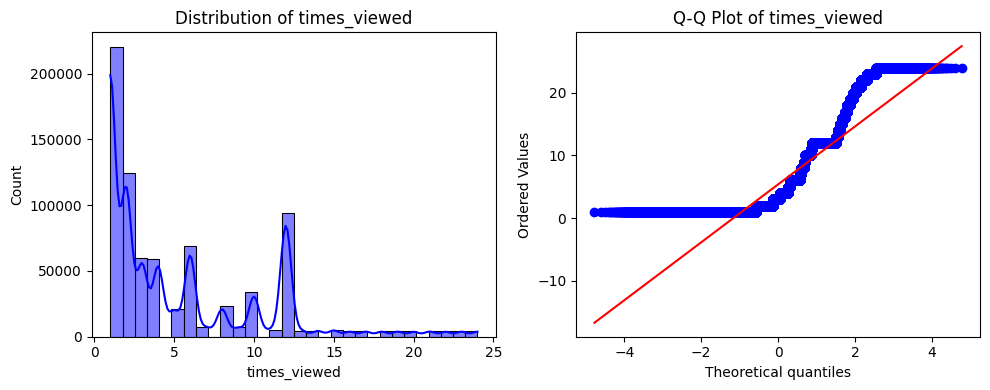

price is not normally distributed (p-value: 0.000)


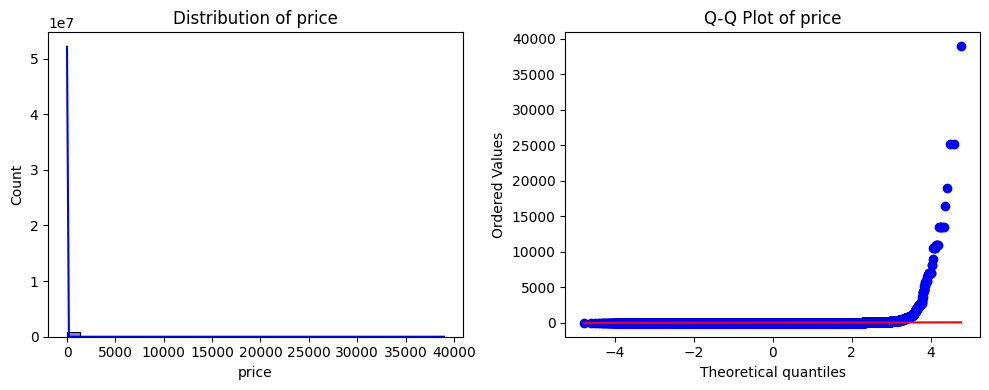

In [8]:

# Plot distribution and check for normality
for col in numerical_cols:
    plt.figure(figsize=(10, 4))
    
    # Plotting the histogram and KDE for each numerical column
    plt.subplot(1, 2, 1)
    sns.histplot(loaded_df[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col}')
    
    # Q-Q plot for normality check
    plt.subplot(1, 2, 2)
    stats.probplot(loaded_df[col], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {col}')
    
    # Shapiro-Wilk Test for normality
    stat, p_value = stats.shapiro(loaded_df[col].dropna())
    
    # Check if p-value is significant (typically less than 0.05 means non-normal distribution)
    if p_value > 0.05:
        print(f'{col} looks normally distributed (p-value: {p_value:.3f})')
    else:
        print(f'{col} is not normally distributed (p-value: {p_value:.3f})')

    plt.tight_layout()
    plt.show()

In [9]:
## Check for Outliers in loaded_df, the iqr method

# Function to find outliers based on IQR for a single column within each country
def find_outliers_index_iqr_by_country(df):
    outliers_index = []  # To store the indices of rows with outliers

    # Iterate over each country in the DataFrame
    for country, group in df.groupby('country'):
        for column in numerical_cols:  
            Q1 = group[column].quantile(0.25)
            Q3 = group[column].quantile(0.75)
            IQR = Q3 - Q1
            
            # Calculate the lower and upper bounds for outliers
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Find indices of outliers in the column
            outliers_in_column = group[(group[column] < lower_bound) | (group[column] > upper_bound)].index
            
            # Extend the outliers_index list with these indices
            outliers_index.extend(outliers_in_column)
    
    # Return the outliers and the cleaned DataFrame
    return outliers_index


# Call the function to detect outliers
iqr_outliers_index_of_loaded_df = find_outliers_index_iqr_by_country(loaded_df)
#loaded_df.loc[outliers_index_of_loaded_df]

# Display the outliers
print("Warning : Outliers detected")
print("There are {:,.0f} rows with outliers".format(loaded_df.loc[iqr_outliers_index_of_loaded_df].shape[0]))
print(f"{(100 * loaded_df.loc[iqr_outliers_index_of_loaded_df].shape[0] / loaded_df.shape[0]):.0f}% of the data seems to be outliers.")


There are 73,697 rows with outliers
10% of the data seems to be outliers.


In [10]:
# Drop rows that contain outliers and return the cleaned DataFrame
cleaned_from_outliers_iqr_loaded_df = loaded_df.drop(index=iqr_outliers_index_of_loaded_df)

# Display the cleaned data shape
print("\nThe loaded_df's total rows before the outlier detection is {:,.0f}".format(loaded_df.shape[0]), "rows")
print("\nThe loaded_df's total rows after the outlier detection is {:,.0f}".format(cleaned_from_outliers_iqr_loaded_df.shape[0]), "rows")


The loaded_df's total rows before the outlier detection is 773,839 rows

The loaded_df's total rows after the outlier detection is 700,367 rows


After droping outliers, times_viewed is not normally distributed (p-value: 0.000)


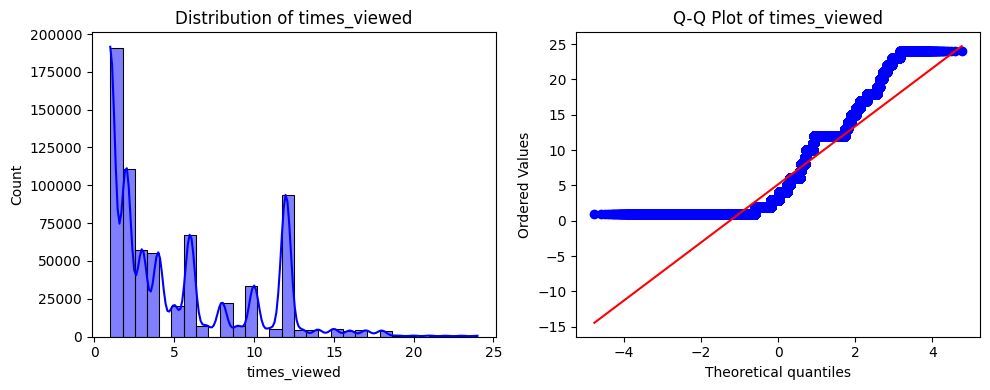

After droping outliers, price is not normally distributed (p-value: 0.000)


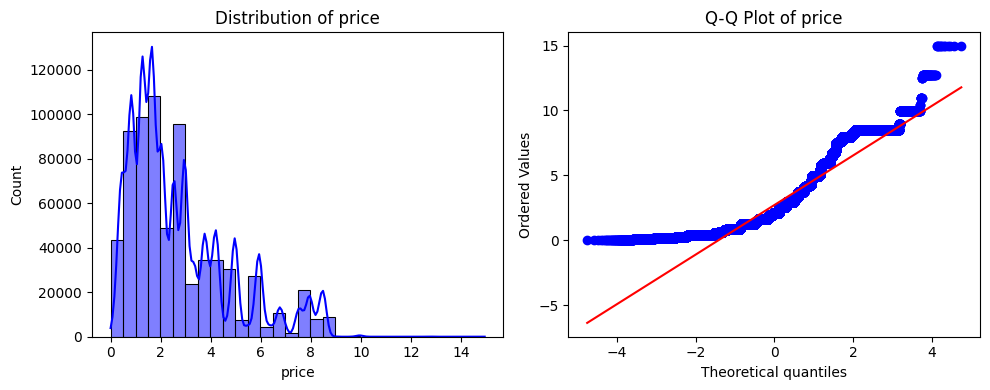

In [11]:
# Plot distribution and check for normality after droping outliers

for col in numerical_cols:
    plt.figure(figsize=(10, 4))
    
    # Plotting the histogram and KDE for each numerical column
    plt.subplot(1, 2, 1)
    sns.histplot(cleaned_from_outliers_iqr_loaded_df[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col}')
    
    # Q-Q plot for normality check
    plt.subplot(1, 2, 2)
    stats.probplot(cleaned_from_outliers_iqr_loaded_df[col], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {col}')
    
    # Shapiro-Wilk Test for normality
    stat, p_value = stats.shapiro(cleaned_from_outliers_iqr_loaded_df[col].dropna())
    
    # Check if p-value is significant (typically less than 0.05 means non-normal distribution)
    if p_value > 0.05:
        print(f'After droping outliers, {col} looks normally distributed (p-value: {p_value:.3f})')
    else:
        print(f'After droping outliers, {col} is not normally distributed (p-value: {p_value:.3f})')

    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.ensemble import IsolationForest

# Function to find outliers based on Isolation Forest for numerical columns within each country
def find_outliers_index_isolation_forest_by_country(df):
    outliers_index = []  

    # Iterate over each country in the DataFrame
    for country, group in df.groupby('country'):
        # Apply IsolationForest for the selected numerical columns
        iso_forest = IsolationForest(contamination=0.1, random_state=42)
        
        # Fit the model and predict outliers (returns -1 for outliers, 1 for inliers)
        outliers = iso_forest.fit_predict(group[numerical_cols])

        # Find indices of outliers (where prediction is -1)
        outliers_in_group = group[outliers == -1].index
        
        # Extend the outliers_index list with these indices
        outliers_index.extend(outliers_in_group)
    
    # Return the outliers' indices
    return outliers_index

# Call the function to detect outliers
outliers_index_IsolationForest_of_loaded_df = find_outliers_index_isolation_forest_by_country(loaded_df)

# Display the outliers
print("Warning : Outliers detected")
print("There are {:,.0f} rows with outliers".format(loaded_df.loc[outliers_index_IsolationForest_of_loaded_df].shape[0]))


In [ ]:
# Drop rows that contain outliers and return the cleaned DataFrame
cleaned_from_outliers_IsolationForest_loaded_df = loaded_df.drop(index=outliers_index_IsolationForest_of_loaded_df)

# Display the cleaned data shape
print("\nThe loaded_df total rows before the outlier detection is {:,.0f}".format(loaded_df.shape[0]), "rows")
print("\nThe loaded_df total rows after the outlier detection is {:,.0f}".format(cleaned_from_outliers_IsolationForest_loaded_df.shape[0]), "rows\n")

In [ ]:
# Plot distribution and check for normality after droping outliers

for col in numerical_cols:
    plt.figure(figsize=(10, 4))
    
    # Plotting the histogram and KDE for each numerical column
    plt.subplot(1, 2, 1)
    sns.histplot(cleaned_from_outliers_IsolationForest_loaded_df[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col}')
    
    # Q-Q plot for normality check
    plt.subplot(1, 2, 2)
    stats.probplot(cleaned_from_outliers_IsolationForest_loaded_df[col], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {col}')
    
    # Shapiro-Wilk Test for normality
    stat, p_value = stats.shapiro(cleaned_from_outliers_IsolationForest_loaded_df[col].dropna())
    
    # Check if p-value is significant (typically less than 0.05 means non-normal distribution)
    if p_value > 0.05:
        print(f'After droping outliers, {col} looks normally distributed (p-value: {p_value:.3f})')
    else:
        print(f'After droping outliers, {col} is not normally distributed (p-value: {p_value:.3f})')

    plt.tight_layout()
    plt.show()

In [ ]:
## Check for Missing Values in cleaned_from_outliers_IsolationForest_loaded_df

missing_values = cleaned_from_outliers_iqr_loaded_df.isnull().sum()
if missing_values.sum() > 0:
    print("\nWarning: There are some missing values in the dataframe")
    print("\nMissing_values Summary\n{}".format("-"*25))
else :
    print("\nThere are no missing values in the dataframe")
    
# Filter for columns with missing values
missing_data = missing_values[missing_values > 0]

# Print the column name and number of missing values
for column, missing_count in missing_data.items():
    print(f"There are {missing_count} missing values in the {column} column\n\nBut since we are not using the {column} column in our analysis, we won't drop rows with missing values")

In [ ]:
## Check for uniqueness of entries in each column of cleaned_from_outliers_IsolationForest_loaded_df

print("\nUniqueness of entries in each column\n{}".format("-"*39))
for column in ['country','date','invoice_id','customer_id','stream_id'] :
    num_unique = cleaned_from_outliers_iqr_loaded_df[column].nunique()           
    
    print(f"There are {num_unique} unique {column}")


## B - Dates investigation


In [ ]:

## Dates Span and Missing Observations

max_date = cleaned_from_outliers_iqr_loaded_df.date.max()
min_date = cleaned_from_outliers_iqr_loaded_df.date.min()

span_dates = (max_date -  min_date).days + 1
nunique_dates = cleaned_from_outliers_iqr_loaded_df.date.nunique()
missing_observations = span_dates - nunique_dates


print(f'\nAs highlighted above, there are {nunique_dates} unique date, but the dates span a range of {span_dates} days \
- starting the {min_date} and ending the {max_date} - giving us {missing_observations} missing observations.\n')

In [ ]:
revenu_over_time = time_series_df(cleaned_from_outliers_iqr_loaded_df, country=None)[['date','year-month','revenue']]

fig = px.line(x=revenu_over_time.date,
        y=revenu_over_time.revenue,
        title='Revenue Over Time')

fig.update_layout(xaxis_title=None,
                  yaxis_title=None,
                  title_x=0.5)

## B - Revenu investigation

In [ ]:
# Group by country and calculate total revenue for each country
revenue_country = (cleaned_from_outliers_iqr_loaded_df[['country', 'price']]
                   .groupby('country', as_index=False)
                   .sum()
                   .rename(columns={'price': 'revenue_'})
                   .sort_values(by='revenue_', ascending=False).reset_index().head(5)
                  )
# Calculate total revenue and percentage contribution for each country, then get the top 5
revenue_country_ = (revenue_country
                   .assign(percentage=lambda df: (df['revenue_'] / df['revenue_'].sum()) * 100)
                   .assign(revenue=lambda df: df['revenue_'].apply(lambda x: f"{x:,.2f}"),
                           percentage=lambda df: df['percentage'].apply(lambda x: f"{x:.2f}%"))
)

# Display the top five revenue-generating countries
print('\nThe top five revenue-generating countries\n')
revenue_country_[['country', 'revenue', 'percentage']]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a bar plot for the top 5 revenue-generating countries
plt.figure(figsize=(10, 6))
sns.barplot(x=revenue_country.revenue_.tolist(), 
            y=revenue_country.country.tolist(), 
            data=revenue_country, 
            palette='viridis')

# use a log scale
plt.xscale('log') 

# Add labels and title
plt.xlabel('Revenue')
plt.ylabel('Country')
plt.title('Top 5 Revenue-Generating Countries')

# Display the plot
plt.show()


In [ ]:
# Calculate revenue ratio
revenue_ratio = (revenue_country['revenue_'].iloc[0] /
                 revenue_country['revenue_'].iloc[1:].sum()).round(0)
print(f'\nThe revenue generated by {revenue_country["country"].iloc[0]} is approximately '
      f'{revenue_ratio} times greater than the combined revenue of the next four countries.\n')

## D - Streams investigation

In [ ]:
# Identify the most frequent stream_id
stream_id_counts = cleaned_from_outliers_iqr_loaded_df['stream_id'].value_counts()
most_frequent_streams = stream_id_counts[stream_id_counts > 1999]
print("\nThe most frequent stream_ids:")
print(most_frequent_streams)



In [ ]:
# Analyze the relationship between stream_id and times_viewed
stream_times_viewed = cleaned_from_outliers_iqr_loaded_df.groupby('stream_id')['times_viewed'].mean().sort_values(ascending=False)
print("\nAverage number of times a stream was viewed:")
print(stream_times_viewed)

# Analyze the relationship between stream_id and price
stream_price = cleaned_from_outliers_iqr_loaded_df.groupby('stream_id')['price'].mean().sort_values(ascending=False)
print("\nAverage price per stream_id:")
print(stream_price)


In [ ]:
# Analyze the relationship between stream_id and times_viewed
stream_times_viewed = cleaned_from_outliers_iqr_loaded_df.groupby('stream_id')['times_viewed'].mean().sort_values(ascending=False)
print("\nAverage number of times a stream was viewed:")
print(stream_times_viewed)

# Analyze the relationship between stream_id and price
stream_price = cleaned_from_outliers_iqr_loaded_df.groupby('stream_id')['price'].mean().sort_values(ascending=False)
print("\nAverage price per stream_id:")
print(stream_price)


In [ ]:
--------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------

# 3 - Testable Hypotheses

In order to derive meaningful insights from the dataset, we propose a series of testable hypotheses that explore the relationships between various factors influencing revenue generation. 
These hypotheses aim to identify key trends and patterns in user behavior, seasonal effects, and the effectiveness of different subscription models, ultimately guiding strategic decision-making for this business opportunity.

### Hypothesis 1: Revenue Prediction by Country

`Statement` : The monthly revenue from the top five countries is significantly different from each other.

`Involved Fields` : country, price, year-month

`Target` : The Monthly Revenue which is the total revenue generated in a given month for each country.

`Business Metric` : The Revenue Variance Across Countries: The key business metric to be evaluated is whether the monthly revenue varies significantly across the top ten countries. This is critical for understanding market performance and tailoring the company's revenue generation strategies accordingly.

---------------------------------------------------------------------------------------------------------------------------------------------

`Data Aggregation`: Aggregate the data by country, year, and month to calculate the total monthly revenue for each country. This can be achieved by summing the price for each combination of country, year, and month.
The resulting dataset will have fields: country, year, month, and monthly_revenue.

`Statistical Analysis`:
- Statistical tests (e.g., ANOVA) : To compare the monthly revenues across the top five countries. This will help determine if there are statistically significant differences in revenue generation.
- Calculate summary statistics (mean, median, variance) for monthly revenue in each country to assess overall performance and variability.

`Visualizations` : Depict the distribution of monthly revenue across the top ten countries. This will help in identifying outliers and trends visually.  
Time series plots can also be beneficial to show trends over time for each country, highlighting seasonal patterns or anomalies.

`Correlation Analysis`: Explore correlations between monthly revenue and other factors such as times_viewed, if applicable. This could provide insights into whether user engagement impacts revenue generation.

`Insights Extraction`:   
Based on the results of the statistical tests and visualizations, draw conclusions about the revenue generation capabilities of each country. Identify which countries are performing well and which are underperforming.
Assess whether external factors (e.g., economic conditions, cultural events) correlate with the observed revenue patterns, which could inform strategic decisions.


In [ ]:

# Working only with the The top five revenue-generating countries
countries = revenue_country.country.tolist()

# Initialize an empty list to store DataFrames
violin_df = None

# Combining the DataFrames for each country into a single DataFrame
for country in countries:
    # Creating an concatenated df 
    df = time_series_df(cleaned_from_outliers_iqr_loaded_df, country=country)
    df['country'] = country
    # Concatenate all DataFrames into one
    if violin_df is None:
        violin_df = df.copy()
    else:
        violin_df = pd.concat([violin_df, df], ignore_index=True)  

# Plotting the violinplot
sns.violinplot(x='country', y='revenue', data=violin_df)  # Remove scale='log'
plt.yscale('log')  # Set y-axis to log scale
plt.title('Boxplot of Daily Log Revenues\nfor Each Country')
plt.xlabel('Country')
plt.ylabel('Daily Log Revenue')  # Update label to reflect log scale
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Overall, the violin plot suggests that the United Kingdom is the top revenue-generating country with a higher median revenue and a wider range of daily revenue. The other countries have similar distributions of daily revenue, with a median close to 0 and a smaller spread.

Based on these observations, we might expect to find significant differences in mean revenues among the countries, especially between the United Kingdom and the other countries. However, ANOVA analysis would be necessary to confirm this statistically.

In [ ]:
countries = revenue_country.country.tolist()
anova_long_df = None

for country in countries:
     # Adding the country name as a prefix to each country revenue column in the below df
    revenue_column = country.replace(" ", "_") + "_revenue"
    # Creating an aggregated df by year-month and monthly revenue for each country.
    df = (time_series_df(cleaned_from_outliers_iqr_loaded_df, country=country)
          .groupby('year-month')
          .agg(sum_revenue = ('revenue', 'sum') )
          .round(2)
          .reset_index()
         ) 
    df['country'] = country

    if anova_long_df is None:
        anova_long_df = df.copy()
    else:
        anova_long_df = pd.concat([anova_long_df, df], ignore_index=True)  

anova_long_df = anova_long_df.fillna(0)
anova_long_df



In [ ]:

# Step 1: Group by country
for country, group in anova_long_df.groupby('country'):
    print(f"\nNormality test of sum_revenue data for {country}:")
    
    # Step 2: Perform the Shapiro-Wilk test on sum_revenue for each country
    stat, p_value = shapiro(group['sum_revenue'])
    
    # Step 3: Print the test results
    print(f"Shapiro-Wilk test statistic: {stat}, p-value: {round(p_value,2)}, Sample Size: {group.shape[0]}")
    
    # Interpretation of the p-value
    if p_value > 0.05:
        print(f"\nThe sum_revenue for {country} appears to be normally distributed (fail to reject H0)\n")
    else:
        print(f"\nThe sum_revenue for {country} does not appear to be normally distributed (reject H0)\n\
But since the sample size is greater that 20, the CLT helps to mitigate normality concerns.")
    
    # Step 4: Plot the distribution of sum_revenue for visual inspection
    plt.figure(figsize=(10, 5))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(group['sum_revenue'], kde=True)
    plt.title(f'{country} - Histogram of sum_revenue')
    
    # Q-Q plot for normality check
    plt.subplot(1, 2, 2)
    stats.probplot(group['sum_revenue'], dist="norm", plot=plt)
    plt.title(f'{country} - Q-Q Plot of sum_revenue')
    
    plt.tight_layout()
    plt.show()


In [ ]:

groups = [group['sum_revenue'].values for name, group in anova_long_df.groupby('country')]

# Perform Levene's test
stat, p_value = levene(*groups)

# Print the result
print(f"Levene's Test statistic: {stat}, p-value: {p_value}")

# Interpretation
if p_value > 0.05:
    print("The variances across countries are approximately equal (fail to reject H0).")
else:
    print("The variances across countries are significantly different (reject H0).")


In [ ]:
# Group the data by country
groups = [group['sum_revenue'].values for name, group in anova_long_df.groupby('country')]

# Perform Welch's ANOVA
def welch_anova(*groups):
    k = len(groups)  # number of groups
    # Calculate the means and variances for each group
    means = [np.mean(g) for g in groups]
    vars = [np.var(g, ddof=1) for g in groups]  # sample variance
    ns = [len(g) for g in groups]  # sample sizes

    # Calculate the Welch's ANOVA statistic
    num = sum(n * (mean - np.mean(means))**2 for n, mean in zip(ns, means))
    denom = sum((n - 1) * var for n, var in zip(ns, vars))

    F = num / denom
    return F

# Calculate F-statistic
F_stat = welch_anova(*groups)

# Calculate p-value using the F-distribution
dfn = len(groups) - 1  # numerator degrees of freedom
dfd = sum(len(g) - 1 for g in groups)  # denominator degrees of freedom
p_value = 1 - f.cdf(F_stat, dfn, dfd)

# Print the results
print(f"Welch's ANOVA F-statistic: {round(F_stat,4)}, p-value: {round(p_value,4)}")

# Interpretation of results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis: There are significant differences in sum_revenue among countries.")
else:
    print("Fail to reject the null hypothesis: No significant differences in sum_revenue among countries.")
    
# Further interpretation
if p_value < alpha:
    print("Post-hoc tests (e.g., Tukey's HSD) can be conducted to identify which countries have significant differences in revenue.")
else:
    print("Since there are no significant differences, post-hoc tests are not necessary.")

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit the model
model = ols('sum_revenue ~ C(country)', data=anova_long_df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Displaying the results
print('\nANOVA TABLE\n{}'.format("-"*59))
display(anova_table)
print(("-"*59))
# Interpretation
if anova_table['PR(>F)'][0] < 0.05:
    print("\nWe reject the null hypothesis and accept the alternative one stating that :\nThere are significant differences in monthly revenue generation across countries.\n")
else:
    print("\nWe fail to reject the null hypothesis stating that :\nThere are no significant differences in monthly revenue generation across countries.\n")
# Further interpretation
if p_value < alpha:
    print("Post-hoc tests (e.g., Tukey's HSD) can be conducted to identify which countries have significant differences in revenue.")
else:
    print("Since there are no significant differences, post-hoc tests are not necessary.")

##### Let's dive a little deeper into the analysis and perform Tukey's HSD (Honestly Significant Difference) test which is a popular choice
#####  for pairwise comparisons identifying which specific country differ significantly from each other after the ANOVA result.

In [ ]:
import statsmodels.stats.multicomp as smc

# Perform Tukey's HSD Test
tukey_results = smc.pairwise_tukeyhsd(anova_long_df['sum_revenue'], anova_long_df['country'])
print('\n', tukey_results, '\n')

# Interpretation of Tukey's HSD results
print("\nTukey's HSD Results Interpretation:\n")
for idx, row in enumerate(tukey_results.summary()):
    if idx == 0:  # skip the header row
        continue
    group1, group2, meandiff, p_adj, lower, upper, reject = map(str, row)  # Convert each cell to string
    meandiff = float(meandiff)  # Convert mean difference to float
    p_adj = float(p_adj)  # Convert adjusted p-value to float

    if reject == 'True':  # Check if reject is a string representation of boolean
        print(f"There is a significant difference between {group1} and {group2}")
    else:
        print(f"There is no significant difference between {group1} and {group2}")
print("\n")

The Tukey HSD test confirms that the United Kingdom has significantly higher mean revenue compared to the other countries.  


However, there are no significant differences in mean revenue among the other four countries.

In [ ]:
--------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------

### Hypothesis 2: Impact of User Engagement on Revenue

`Statement`: Higher times viewed of a service correlates with increased revenue generated from that service.

``Involved Fields``: times_viewed, price, year, month, country

`Target` : The Monthly Revenue which is the total revenue generated in a given month for each country.

`Business Metric` : The Correlation Between User Engagement and Revenue: The key business metric to evaluate is the relationship between times_viewed and monthly revenue. Understanding this relationship is essential for optimizing marketing efforts and improving revenue generation strategies.

---------------------------------------------------------------------------------------------------------------------------------------------

`Data Aggregation`: Aggregate the data by country, year, month, and potentially by service type (if available) to calculate the total monthly revenue and total times viewed for each service.
The resulting dataset will have fields: country, year, month, total_times_viewed, and monthly_revenue.

`Statistical Analysis` : 
- Use correlation coefficients (e.g., Pearson or Spearman correlation) to quantify the relationship between total_times_viewed and monthly revenue. A positive correlation would indicate that higher views are associated with increased revenue.
- Conduct regression analysis (e.g., linear regression) to model the relationship between times_viewed and monthly revenue, controlling for other factors such as country, year, and month. This can provide insights into how much of the variance in revenue can be explained by user engagement.

`Visualizations`: Create scatter plots to visualize the relationship between total_times_viewed and monthly revenue. Adding a trend line can help illustrate any potential correlation.
Box plots can be useful to show the distribution of monthly revenue for different ranges of times_viewed, highlighting potential outliers and the central tendency.

`Insights Extraction`: Based on the results of the correlation and regression analyses, draw conclusions about the strength and nature of the relationship between user engagement (measured by times_viewed) and revenue generation.
Identify whether increasing user engagement strategies (like improved marketing or user experience) could potentially lead to higher revenues.

`Considerations`: It’s important to control for other confounding variables that might influence both times_viewed and monthly revenue. Factors such as seasonality, pricing changes, or marketing campaigns could be included in a multivariate analysis.

In [ ]:

time_series_cleaned_from_iqr_outliers_loaded_df = time_series_df(cleaned_from_outliers_iqr_loaded_df, country=None)
display(time_series_cleaned_from_iqr_outliers_loaded_df.head())

In [ ]:
grouped_time_series_cleaned_from_iqr_outliers_loaded_df = (time_series_cleaned_from_iqr_outliers_loaded_df
                                                                       .groupby('year-month')
                                                                       .sum(numeric_only=True)
                                                                       .reset_index()
                                                                      )

grouped_time_series_cleaned_from_iqr_outliers_loaded_df

In [ ]:
# Function to check for normality
def check_normality(df):
    for column in df.select_dtypes(include=[np.number]).columns:
        # Shapiro-Wilk Test
        stat, p = shapiro(df[column])
        print(f'\nShapiro-Wilk test for {column}: statistic = {stat:.3f}, p-value = {p:.3f}')
        # Interprettaions
        if p < 0.05:
            print(f'-> {column} are not normally distributed (reject H0)\n')
        else:
            print(f'-> {column} are normally distributed (fail to reject H0)\n')

            
        # Plot the distribution of the column for visual inspection
        plt.figure(figsize=(10, 5))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[column], kde=True)
        plt.title(f'Distribution of {column}')
    
        # Q-Q plot for normality check
        plt.subplot(1, 2, 2)
        stats.probplot(df[column], dist="norm", plot=plt)
        plt.title(f'Q-Q Plot of {column}')
    
        plt.tight_layout()
        plt.show()

# Check normality

check_normality(grouped_time_series_cleaned_from_iqr_outliers_loaded_df)

In [ ]:
numerical_columns = grouped_time_series_cleaned_from_iqr_outliers_loaded_df.select_dtypes(include=['number']).columns.tolist()

corr_matrix_spearman = grouped_time_series_cleaned_from_iqr_outliers_loaded_df[numerical_columns].corr(method='spearman')

fig , ax = plt.subplots(figsize=(7,7))
mask = np.triu(np.ones_like(corr_matrix_spearman))
ax=sns.heatmap(corr_matrix_spearman,
               annot=True, fmt='.2f', ax=ax , linewidth=0.5,
               vmin=-1, vmax=1, mask=mask, cmap='BrBG', cbar=True)
ax.set_title('The correlation heatmap');



The data indicates that user engagement metrics (purchases, streams, and views) are related to one another, and have a direct impact on revenue.


Customer Engagement: The strong correlations between unique streams, total views, and revenue suggest that increasing customer engagement through more content views and unique streams is a key driver of revenue growth.


Sales Funnel: The relationship between unique invoices and the other variables indicates that while unique invoices are important, they may not be the sole determinant of revenue. Factors like customer engagement and content consumption also play significant roles.

Let's statisticaly assesse this finding.

In [ ]:
print("\n")

# Iterate over each column pair
for column in numerical_columns :
    if column != 'revenue':  

        # Calculate the Pearson correlation coefficient and p-value
        correlation_coefficient, p_value = spearmanr(grouped_time_series_cleaned_from_iqr_outliers_loaded_df['revenue'],
                                                     grouped_time_series_cleaned_from_iqr_outliers_loaded_df[column])

        # Interpret the results and print
        significance = "significant" if p_value < 0.05 else "no significant"
        print(f"There is a {significance} correlation between the revenue' and the {column}.")
        print(f"Correlation coefficient: {correlation_coefficient:.2f}")
        print('-' * 50)
print("\n")

In [ ]:
# Pairplot to visualize relationships
sns.pairplot(grouped_time_series_cleaned_from_iqr_outliers_loaded_df,
             x_vars=['purchases', 'unique_invoices', 'unique_streams', 'total_views'], 
             y_vars='revenue'
            )
plt.suptitle("Pairplot: Revenue vs Other Variables", y=1.02)
plt.show()

The independent variables are ['purchases', 'unique_invoices', 'unique_streams', 'total_views'] while the dependent variable is 'revenue'

So to tackle the multicollinearity between predictors, we ll use Ridge regression, feature selection, and feature engineering to perform a regression analysis.

In [ ]:
# here we construct a feature

df_reg = grouped_time_series_cleaned_from_IsolationForest_outliers_loaded_df

# Feature Engineering: Create a new feature for engagement
df_reg['engagement'] = df_reg['unique_streams'] + df_reg['total_views']

# Prepare the data for Ridge regression
X = df_reg[['purchases', 'unique_invoices', 'engagement']]
y = df_reg['revenue']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Ridge regression model
ridge_model = Ridge(alpha=1.0)  # You may tune alpha using cross-validation
ridge_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = ridge_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# Output the results
print(f'Mean Squared Error: {mse}')
print('Coefficients:', ridge_model.coef_)

the results are bad so we will not use feature engenieering, instead we ll perform feature selection by iterating over the predictors and finding the best combination of predictors that provides the lowest Mean Squared Error

In [ ]:

# Define the features and target variable
X = df_reg[['purchases', 'unique_invoices', 'unique_streams', 'total_views']]
y = df_reg['revenue']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize variables to track the best model
best_mse = float('inf')
best_features = None

# Iterate through all combinations of predictors
features = X.columns
num_features = len(features)

for i in range(1, num_features + 1):
    for combination in itertools.combinations(features, i):
        # Train the model with the selected features
        model = RidgeCV(alphas=np.logspace(-6, 6, 13), store_cv_values=True)
        model.fit(X_train[list(combination)], y_train)
        
        # Make predictions and calculate MSE
        predictions = model.predict(X_test[list(combination)])
        mse = mean_squared_error(y_test, predictions)

        # Check if this is the best model
        if mse < best_mse:
            best_mse = mse
            best_features = combination

# Output the best model results
print("Best features:", best_features)
print("Best Mean Squared Error:", best_mse)

Using the best features identified during feature selection we build a simple linear regression model for clear interpretability.

In [ ]:
# Prepare the features and target variable
selected_features = list(best_features)
X = df_reg[selected_features]
y = df_reg['revenue']

# Add a constant to the model
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

The OLS regression results indicate a strong model with an R-squared of 0.813, suggesting that approximately 81.3% of the variance in monthly revenue across all country can be explained by our predictors: purchases, unique streams, and total views. 

The significant coefficient for purchases (p = 0.002) implies a positive relationship, while total views shows a significant negative impact (p = 0.046).

In [ ]:
--------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------

### Hypothesis 3: Seasonal Revenue Trends

`Statement`: Monthly revenue exhibits seasonal trends, indicating certain months generate higher revenue than others.

`Involved Fields`: year, month, price

`Target` : The Monthly Revenue which is the total revenue generated in a given month for each country.

`Business Metric` : Seasonal Revenue Trends: The key business metric to evaluate is whether monthly revenue varies significantly across different months of the year. Understanding these trends is vital for planning marketing efforts, budgeting, and staffing.

---------------------------------------------------------------------------------------------------------------------------------------------

`Data Aggregation`: Aggregate the data by year and month to calculate the total monthly revenue. This involves summing the price for all transactions that occur in that month for each year.
The resulting dataset will have fields: year, month, and monthly_revenue.

`Statistical Analysis` : 
- Perform a time series analysis to evaluate seasonal patterns in the monthly revenue data. This could involve using methods such as Seasonal Decomposition of Time Series (STL) to separate the seasonal component from the trend and residual components.
- Conduct ANOVA tests to determine if there are statistically significant differences in monthly revenue across different months.

`Visualizations`: Create line plots to visualize monthly revenue over multiple years. This can help identify seasonal patterns and trends, showing which months consistently generate higher revenue.
Box plots can also be useful to display the distribution of monthly revenue for each month across different years, highlighting variations and potential outliers.

`Insights Extraction`: Based on the results of the seasonal decomposition and statistical tests, draw conclusions about which months generate higher revenue and whether these patterns are consistent across years.
Identify factors that might influence seasonal trends, such as holidays, special events, or seasonal marketing campaigns.

`Considerations`: It's important to consider external factors that may affect revenue in certain months (e.g., economic conditions, industry trends, or competition). Understanding these factors can provide context for the observed seasonal patterns.


In [ ]:
time_series_cleaned_from_iqr_outliers_loaded_df = time_series_df(cleaned_from_outliers_iqr_loaded_df, country=None)

df = time_series_cleaned_from_iqr_outliers_loaded_df.copy()
# Set 'date' as datetime and index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
display(df.head(2))

In [ ]:
# 1. Plot Revenue Time Series
fig = px.line(df, x=df.index, y='revenue', title='Daily Revenue Over Time', labels={'revenue': 'Revenue', 'index': 'Date'})
fig.update_layout(xaxis_title='',
                  yaxis_title='',
                  width=1200,  
                  height=600)                   
fig.show()




In [ ]:
# 2. Check for Stationarity using ADF Test
result = adfuller(df['revenue'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print(f'Critical Values {key}: {value}')

ADF Statistic: Since the ADF statistic (-4.53) is less than all the critical values (especially the 5% and 1% levels), this suggests that we can reject the null hypothesis of non-stationarity.

p-value: The p-value (0.00017) is much less than 0.05, further indicating that the series is stationary.

Since our time series is stationary, we can proceed with the analysis without needing any transformations for stationarity. 

## Smoothing using Moving Average

In [ ]:
# 1. Calculate the monthly moving average
window_size = 31  # Monthly window
df['revenue_smooth'] = df['revenue'].rolling(window=window_size).mean()

# 2. Create a figure using Plotly
fig = go.Figure()

# 3. Add original revenue line
fig.add_trace(go.Scatter(x=df.index, y=df['revenue'], mode='lines', name='Original', line=dict(color='blue')))

# 4. Add smoothed revenue line
fig.add_trace(go.Scatter(x=df.index, y=df['revenue_smooth'], mode='lines', name=f'{window_size}-day Moving Average', line=dict(color='red')))

# 5. Update layout with larger dimensions
fig.update_layout(title='Original vs Smoothed Revenue',
                  xaxis_title='Date',
                  yaxis_title='Revenue',
                  legend_title='Legend',
                  width=1200,  
                  height=600)  

# 6. Show the plot
fig.show()

In [ ]:

# Time Series Decomposition of Revenue
decomposition = seasonal_decompose(df['revenue'], model='additive', period=31)  # Assuming monthly seasonality

# Create a figure with subplots
fig = make_subplots(rows=4, cols=1, shared_xaxes=False, vertical_spacing=0.05)

# Plot Observed Revenue
fig.add_trace(go.Scatter(x=decomposition.observed.index, 
                         y=decomposition.observed, 
                         mode='lines', name='Observed', line=dict(color='blue')), row=1, col=1)

# Plot Trend Component
fig.add_trace(go.Scatter(x=decomposition.trend.index, 
                         y=decomposition.trend, mode='lines', 
                         name='Trend', line=dict(color='orange')), row=2, col=1)

# Plot Seasonal Component
fig.add_trace(go.Scatter(x=decomposition.seasonal.index, 
                         y=decomposition.seasonal, mode='lines', 
                         name='Seasonal', line=dict(color='green')), row=3, col=1)

# Plot Residual Component
fig.add_trace(go.Scatter(x=decomposition.resid.index, 
                         y=decomposition.resid, mode='markers', 
                         name='Residual', line=dict(color='purple')), row=4, col=1)

# Update layout with titles and horizontal line at 0
fig.update_layout(title='Time Series Decomposition of Revenue', 
                  margin=dict(t=100, b=50, l=50, r=50),
                  width=1100,  
                  height=1500,
                  legend=dict(x=.89, y=1.05, traceorder='normal', orientation='v', 
                              bgcolor='rgba(255, 255, 255, 0)', bordercolor='Black',
                              borderwidth=1)
                 )

# Add horizontal line at y=0 for each subplot
for i in range(1, 5):
    fig.add_shape(type='line', x0=decomposition.observed.index.min(), x1=decomposition.observed.index.max(), y0=0, y1=0,
                  line=dict(color='red', dash='dash'), row=i, col=1)

# Set subplot titles with adjusted positions
fig.add_annotation(text='Observed Revenue', x=0.5, y=1.02, xref='paper', yref='paper', showarrow=False, font=dict(size=16))
fig.add_annotation(text='Trend Component', x=0.5, y=0.76, xref='paper', yref='paper', showarrow=False, font=dict(size=16))
fig.add_annotation(text='Seasonal Component', x=0.5, y=0.49, xref='paper', yref='paper', showarrow=False, font=dict(size=16))
fig.add_annotation(text='Residual Component', x=0.5, y=0.22, xref='paper', yref='paper', showarrow=False, font=dict(size=16))

# Show the plot
fig.show()


Since the series is stationary, you may not need to apply Box-Cox transformation. However, it’s still beneficial to visualize the residuals after smoothing or decomposition to confirm there is no changing variance.


In [ ]:
# Box-Cox Transformation to remove changing variance


df['boxcox_revenue'], lmbda = stats.boxcox(df['revenue'].replace(0, np.nan).dropna())

plt.figure(figsize=(10, 6))
sns.lineplot(x=df.index, y=df['boxcox_revenue'])
plt.title('Box-Cox Transformed Revenue')
plt.xlabel('Date')
plt.ylabel('Transformed Revenue')
plt.show()




In [ ]:
# Analyze Changing Variance:
# Visualize the residuals after smoothing or decomposition to confirm there is no changing variance.

fig = go.Figure()

# Add the residuals line
fig.add_trace(go.Scatter(x=decomposition.resid.index, y=decomposition.resid, 
                         mode='markers', showlegend=False ,
                        )
             )

# Add a horizontal line at 0
fig.add_trace(go.Scatter(x=decomposition.resid.index, y=[0] * len(decomposition.resid), 
                         mode='lines', showlegend=False ,
                         line=dict(color='red', dash='dash')
                        )
             )

# Update layout
fig.update_layout(title='Residuals After Decomposition',
                  xaxis_title='',
                  yaxis_title='Residuals',
                  width=1200,  
                  height=600,
                 )
# Show the plot
fig.show()


In [ ]:
def create_corr_plot(series, plot_pacf=False, nlags=40):
    # Calculate ACF or PACF
    corr_array = sm.tsa.pacf(series.dropna(), alpha=0.05, nlags=nlags) if plot_pacf else sm.tsa.acf(series.dropna(), alpha=0.05, nlags=nlags)
    
    # Calculate confidence intervals
    n = len(series.dropna())
    conf_interval = 1.96 / np.sqrt(n)  # 95% CI
    lower_y = corr_array[1][:, 0] - corr_array[0]
    upper_y = corr_array[1][:, 1] - corr_array[0]

    # Create figure
    fig = go.Figure()

    # Add lines for the correlation values
    for x in range(len(corr_array[0])):
        fig.add_scatter(x=(x, x), y=(0, corr_array[0][x]), mode='lines', line_color='#3f3f3f')

    # Add markers for the correlation values
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', 
                    marker_color='#1f77b4', marker_size=12)

    # Add confidence interval fill
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', 
                    line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines', 
                    fillcolor='rgba(32, 146, 230, 0.3)', fill='tonexty', 
                    line_color='rgba(255,255,255,0)')

    # Update layout
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1, nlags + 1])
    fig.update_yaxes(zerolinecolor='#000000')

    title = 'Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title, margin=dict(t=50, b=10, l=50, r=50), height=500)

    # Show the figure
    fig.show()

# Call the function for ACF
create_corr_plot(df['revenue'], plot_pacf=False, nlags=30)

# Call the function for PACF
create_corr_plot(df['revenue'], plot_pacf=True, nlags=30)


In [ ]:
Based on the provided autocorrelation and partial autocorrelation plots, differencing is likely not necessary

In [ ]:
import plotly.express as px

# Create a differenced revenue plot using Plotly Express
fig_diff_revenue = px.line(
    df,
    x=df.index,
    y='diff_revenue',
    title='Differenced Revenue Over Time',
    labels={'diff_revenue': 'Differenced Revenue', 'index': 'Date'}
)

# Update layout for better appearance
fig_diff_revenue.update_layout(
    xaxis_title='Date',
    yaxis_title='Differenced Revenue',
    width=1100,
    height=600
)

# Show the plot
fig_diff_revenue.show()
